# NLP Workshop Part-2
### Text Analysis

---

Text is an extremely rich source for data. Tapping into it can yield great insights, but creating a pipeline from raw data to metrics and visualizations often feels like it requires more grit and luck than anything else.

The first workshop focused mainly on methods for cleaning data and visualizing results with word clouds.

The second session will focus on analysis of text including word similarity, and analysis of tweets from news organizations during the 2014 ebola outbreak. 

---

**Contents:**

* text / document similarity
    - Levenshtein distance, Jaccard score, cosine similarity
* tweets
    - sentiment analysis, topic modeling

# new installs

1. Try running pip install Levenshtein
2. If that works, move on, if not then run xcode install (will take a few minutes)
3. Try installing Levenshtein, if that doesn't work, run xcode reset first
4. If it's too much, skip it for now, we only need this package for two cells

In [1]:
# !xcode-select --install

In [2]:
# !xcode-select --reset

In [3]:
# !pip install python-Levenshtein

VADER is less finicky, just un-comment and run the line below.

In [4]:
# !pip install vaderSentiment

# imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import re
import helpers
from collections import Counter
from datetime import datetime as dt

import Levenshtein

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF

# text and document similarity


### word similarity

Common examples of using word similarity are spell-checking and deduplicating names. The latter is a personal favorite, as running across Excel files with 10s of thousands of manually entered names has taught me a valuable lesson - people suck at spelling names. Names can be tricky, and I assume that this happens to everyone, so here are some of the ways I've been saluted in emails:

- Nathanael
- Nathanial
- Nathaniel
- Nathainel
- Nahtaniel

Why not just go by Nathan? Because Nathan is for people who can't decide if they're a Nathaniel or a Jonathan.

I digress.

There are two fundamental algorithms for handling single word simularity: Levenshtein distance - the number of removals, insertions, or replacements to change one word to another; Jaccard score - the norm of the intersection divided by the norm of the union of unique letters in two words.

In [6]:
# f -> r

Levenshtein.distance('fun', 'run')

1

In [7]:
# dirty, gritty
# + g ; d -> r ; r -> t

Levenshtein.distance('dirty', 'gritty')

3

In [8]:
def jaccard_score(a, b):
    '''return intersection of sets over their union'''
    return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))

In [9]:
# len(['a', 't']) / len(['a', 'b', 'c', 't'])
# 2 / 4

jaccard_score('cat', 'bat')

0.5

In [10]:
# len(['i', 'r', 't', 'y']) / len(['d', 'g', 'i', 'r', 't', 'y'])
# 4 / 6

jaccard_score('dirty', 'gritty')

0.6666666666666666

### Document similarity

...is exponentially trickier to handle. What's the best approach? That depends.

Generally speaking, cosine similarity can give a good indication of which documents are closest in terms of their words. It's a good first step.

In [11]:
def cosine_similarity(a, b):
    '''returns the angle between two vectors'''
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [12]:
# some fake sentences

sentences = [
    'blue green blue green blue green',
    'green blue grass'
]

In [13]:
# df of word counts

cv = CountVectorizer()
X = cv.fit_transform(sentences)
counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
counts

,blue,grass,green
0,3,0,3
1,1,1,1


In [14]:
# angle between the two sentences, for words the range is [0, 1]

cosine_similarity(counts.iloc[0], counts.iloc[1])

0.8164965809277261

### tf-idf revisited

$tf(t)$: number of times a token ($t$) occurs in the document (CountVectorizer)

$idf(t) = \log \frac{1 + n}{1 + df(t)}+1$ ; where $n$ is the number of documents and $df(t)$ is the number of documents containing $t$

*then* each vector is normalized using the euclidean norm: $v_{norm} = \frac{v}{||v||_2}$

In [15]:
tf = TfidfVectorizer()
X = tf.fit_transform(sentences)
tfdf = pd.DataFrame(X.toarray(), columns=tf.get_feature_names())
tfdf.round(3)

,blue,grass,green
0,0.707,0.000,0.707
1,0.502,0.705,0.502


In [16]:
# the second sentence has a change in relative importance for the words
# i.e. blue:grass:green was 1:1:1, now it's approx 5:7:5
# in contrast, the first sentence has no change

cosine_similarity(tfdf.iloc[0], tfdf.iloc[1])

0.7092972666062739

# data framing

[twitter data source](https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter)

credit to Dr. Amir Karami of the University of South Carolina

First step, get the data into a frame.

In [17]:
tweets = []

names = ['bbc', 'cnn', 'npr']  # some news orgs to use.. ie files that opened
for n in names:
    tweets.extend([i.replace(i.split('|')[0], n) # replace tweetID with org name
                   for i in open(f'data/Health-Tweets/{n}health.txt', encoding='utf8').read().split('\n')])

In [18]:
# checking the first 5 tweets

tweets[:5]

['bbc|Thu Apr 09 01:31:50 +0000 2015|Breast cancer risk test devised http://bbc.in/1CimpJF',
 'bbc|Wed Apr 08 23:30:18 +0000 2015|GP workload harming care - BMA poll http://bbc.in/1ChTBRv',
 "bbc|Wed Apr 08 23:30:18 +0000 2015|Short people's 'heart risk greater' http://bbc.in/1ChTANp",
 "bbc|Wed Apr 08 18:05:28 +0000 2015|New approach against HIV 'promising' http://bbc.in/1E6jAjt",
 "bbc|Wed Apr 08 13:19:33 +0000 2015|Coalition 'undermined NHS' - doctors http://bbc.in/1CnLwK7"]

In [19]:
# using the pipe character, we have 3 columns

source = []  # drop each piece into its own list
time = [] 
text = []

for t in tweets:
    tweet = t.split('|')
    if len(tweet) == 3:  # some tweets have < 3 parts, drop the bad entries
        source.append(tweet[0])
        time.append(tweet[1])
        text.append(tweet[2])

In [20]:
# now into a df

tweet_df = pd.DataFrame(data={'source': source, 
                              'time': time, 
                              'text': text})
tweet_df.head()

,source,time,text
0,bbc,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/...
1,bbc,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc...
2,bbc,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc...
3,bbc,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bb...
4,bbc,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bb...


In [21]:
# time looks funky

test_time = tweet_df['time'][0]
test_time

'Thu Apr 09 01:31:50 +0000 2015'

In [22]:
# changing it to a datetime obj

dt.strptime(test_time[4:], '%b %d %X %z %Y')

datetime.datetime(2015, 4, 9, 1, 31, 50, tzinfo=datetime.timezone.utc)

In [23]:
# first text entry

test_text = tweet_df['text'][0]
test_text

'Breast cancer risk test devised http://bbc.in/1CimpJF'

In [24]:
# removing the url

test_text = re.sub(r'http.*', '', test_text)
test_text

'Breast cancer risk test devised '

In [25]:
# cleaning with the workshop 1 function

helpers.clean(test_text)

'breast cancer risk test devised'

In [26]:
%%time

# %%time is a magic function to let you know how long a cell takes to run

# pulling it all together

tweet_df['time'] = [dt.strptime(t[4:], '%b %d %X %z %Y') for t in tweet_df['time']]
tweet_df['text'] = [re.sub(r'http.*', '', t) for t in tweet_df['text']]  # removing urls
tweet_df['clean_text'] = [helpers.clean(t) for t in tweet_df['text']]  # and keeping the dirty text for stuff

tweet_df.head()

CPU times: user 17.8 s, sys: 3.92 s, total: 21.7 s
Wall time: 22.6 s


,source,time,text,clean_text
0,bbc,2015-04-09 01:31:50+00:00,Breast cancer risk test devised,breast cancer risk test devised
1,bbc,2015-04-08 23:30:18+00:00,GP workload harming care - BMA poll,gp workload harming care bma poll
2,bbc,2015-04-08 23:30:18+00:00,Short people's 'heart risk greater',short people heart risk greater
3,bbc,2015-04-08 18:05:28+00:00,New approach against HIV 'promising',new approach hiv promising
4,bbc,2015-04-08 13:19:33+00:00,Coalition 'undermined NHS' - doctors,coalition undermined nh doctor


In [27]:
# window covered by our data

max(tweet_df['time']) - min(tweet_df['time'])

Timedelta('956 days 11:10:38')

In [28]:
# create dummy variables to represent source org

source_dummies = pd.get_dummies(tweet_df['source'], drop_first=True) # cnn & npr == 0 implies bbc

tweet_df = pd.concat([tweet_df.drop(labels='source', axis=1),
                      source_dummies], axis=1)
tweet_df.head()

,time,text,clean_text,cnn,npr
0,2015-04-09 01:31:50+00:00,Breast cancer risk test devised,breast cancer risk test devised,0,0
1,2015-04-08 23:30:18+00:00,GP workload harming care - BMA poll,gp workload harming care bma poll,0,0
2,2015-04-08 23:30:18+00:00,Short people's 'heart risk greater',short people heart risk greater,0,0
3,2015-04-08 18:05:28+00:00,New approach against HIV 'promising',new approach hiv promising,0,0
4,2015-04-08 13:19:33+00:00,Coalition 'undermined NHS' - doctors,coalition undermined nh doctor,0,0


In [29]:
# unigrams and bigrams of our corpus

cv = CountVectorizer(ngram_range=(1, 2), min_df=5)

X = cv.fit_transform(tweet_df['clean_text'])
counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

print(counts.shape)
counts.head()

(12815, 3424)


,ab,ability,able,abortion,abortion clinic,abortion debate,abortion law,abroad,abuse,ac,...,young people,young woman,younger,youth,yr,yr old,zero,zombie,zone,zumba
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


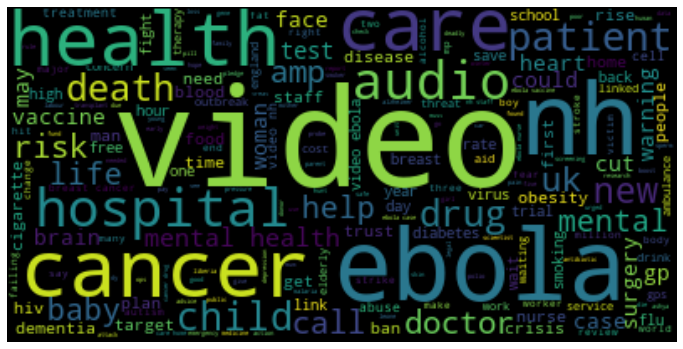

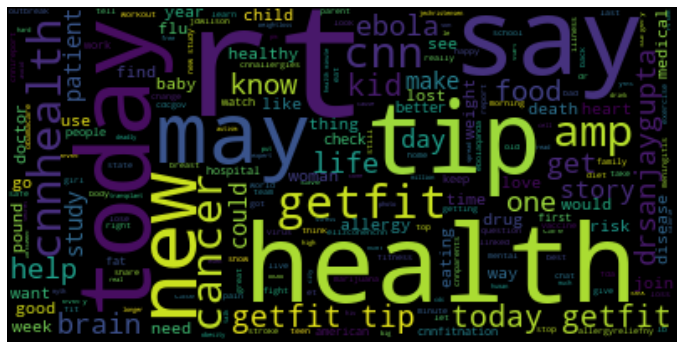

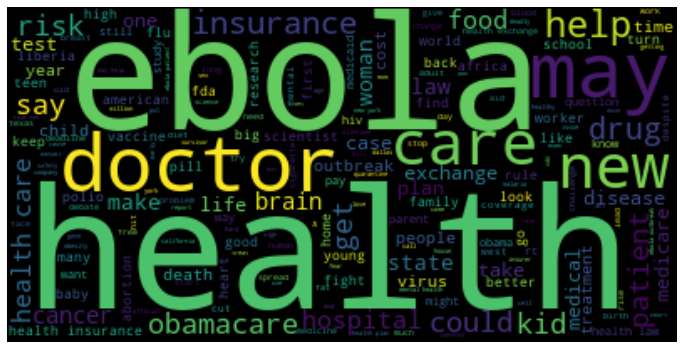

In [30]:
bbc_idx = tweet_df[(tweet_df['cnn'] == 0)&(tweet_df['npr'] == 0)].index
cnn_idx = tweet_df[tweet_df['cnn'] == 1].index
npr_idx = tweet_df[tweet_df['npr'] == 1].index

for idx in [bbc_idx, cnn_idx, npr_idx]:
    helpers.make_cloud(counts.iloc[idx].sum(axis=0))
    print()

In [31]:
# to track 'ebola' mentions over time, we need the associated terms

ebola = [i for i in counts.columns if 'ebola' in i]
print(len(ebola))
ebola

54


['africa ebola',
 'american ebola',
 'british ebola',
 'dallas ebola',
 'deadly ebola',
 'declares ebola',
 'doctor ebola',
 'ebola',
 'ebola case',
 'ebola crisis',
 'ebola death',
 'ebola doctor',
 'ebola drug',
 'ebola emergency',
 'ebola epidemic',
 'ebola fear',
 'ebola fight',
 'ebola free',
 'ebola hit',
 'ebola lockdown',
 'ebola nurse',
 'ebola outbreak',
 'ebola patient',
 'ebola quarantine',
 'ebola response',
 'ebola screening',
 'ebola spread',
 'ebola surge',
 'ebola survivor',
 'ebola test',
 'ebola treatment',
 'ebola vaccine',
 'ebola victim',
 'ebola virus',
 'ebolaoutbreak',
 'ebolaqanda',
 'experimental ebola',
 'fear ebola',
 'fight ebola',
 'first ebola',
 'free ebola',
 'leone ebola',
 'liberia ebola',
 'negative ebola',
 'new ebola',
 'positive ebola',
 'question ebola',
 'reporting ebola',
 'stop ebola',
 'test ebola',
 'treat ebola',
 'treating ebola',
 'uk ebola',
 'video ebola']

In [32]:
# truncating time, we can get ebola mentions by day

tweet_df['date'] = [dt.date(i) for i in tweet_df['time']]
tweet_df['date'][0]

datetime.date(2015, 4, 9)

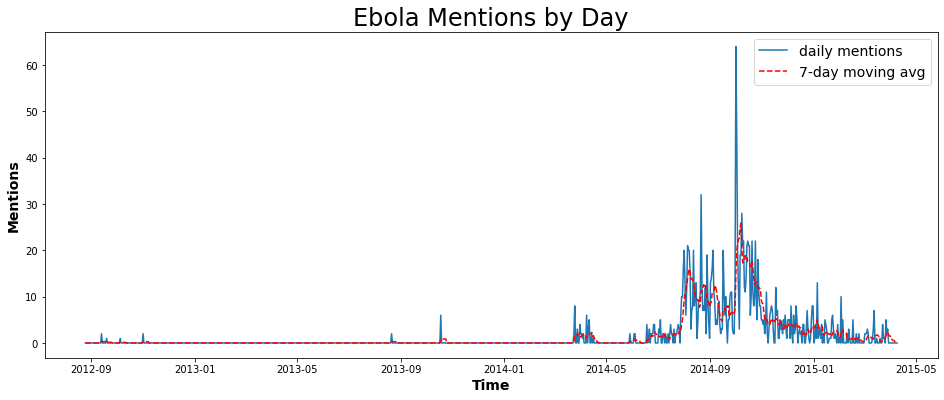

In [33]:
x = sorted(tweet_df['date'].unique())  # time on the x axis

y = [counts.iloc[tweet_df[tweet_df['date'] == i].index][ebola].values.sum() 
     for i in x] # reference the indices of each date to counts, sum up ebola mentions over that slice

# plot settings
plt.figure(figsize=(16, 6))
plt.title('Ebola Mentions by Day', fontsize=24)
plt.ylabel('Mentions', fontweight='bold', fontsize=14)
plt.xlabel('Time', fontweight='bold', fontsize=14)

plt.plot(x, y, label='daily mentions')
plt.plot(x, helpers.moving_avg(y, 7), 'r--', label='7-day moving avg')
plt.legend(fontsize=14);  # 30-day moving average

# sentiment analysis

Sentiment is a generally tricky thing to measure - it's inherently subjective, inflection exists in spoken language but not written, removing stopwords can remove context, all-caps may convey emotion or be used for specific documents, and we can even get into emojis.

The best model will be one that's built or tweaked manually for a specific dataset. Something about elbow grease.

For our purposes here, VADER - Valence Aware Dictionary and sEntiment Reasoner - is a good plug-and-play option for social media sentiment analysis.

[Link to the docs.](https://pypi.org/project/vaderSentiment/)

In [34]:
# setting up the class and a quick-call function

vader = SentimentIntensityAnalyzer()

def get_sentiment(string):
    return vader.polarity_scores(string)

In [35]:
# truly random sample of our text

sample = tweet_df[['text', 'clean_text']].sample(n=5)
sample

,text,clean_text
288,"Cannabis: Promise, risk and controversy",cannabis promise risk controversy
4055,"Want to lose weight, or quit smoking -love ma...",want lose weight quit smoking love may answer ...
9091,"As Ebola Outbreak Worsens, West Africa Turns T...",ebola outbreak worsens west africa turn quaran...
3312,VIDEO: How comics can help bedside manner,video comic help bedside manner
9769,Marijuana Vending Machine Unveiled In Colorado,marijuana vending machine unveiled colorado


In [36]:
# sentiment on raw vs cleaned text

[get_sentiment(i) for i in sample['text']]

[{'neg': 0.284, 'neu': 0.405, 'pos': 0.311, 'compound': 0.0516},
 {'neg': 0.127, 'neu': 0.613, 'pos': 0.259, 'compound': 0.4215},
 {'neg': 0.279, 'neu': 0.721, 'pos': 0.0, 'compound': -0.4767},
 {'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [37]:
[get_sentiment(i) for i in sample['clean_text']]

[{'neg': 0.328, 'neu': 0.312, 'pos': 0.359, 'compound': 0.0516},
 {'neg': 0.19, 'neu': 0.423, 'pos': 0.387, 'compound': 0.4215},
 {'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'compound': -0.4767},
 {'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [38]:
# focusing on compound sentiment seems to make the most sense

def get_sentiment(string):
    '''return compound sentiment score for a string'''
    return vader.polarity_scores(string)['compound']

In [39]:
# sentiment on emojis?

get_sentiment(':)')

0.4588

In [40]:
# caps and exclamation points change scores

get_sentiment('I love milkshakes'), get_sentiment('I LOVE MILKSHAKES!!!')

(0.6369, 0.7249)

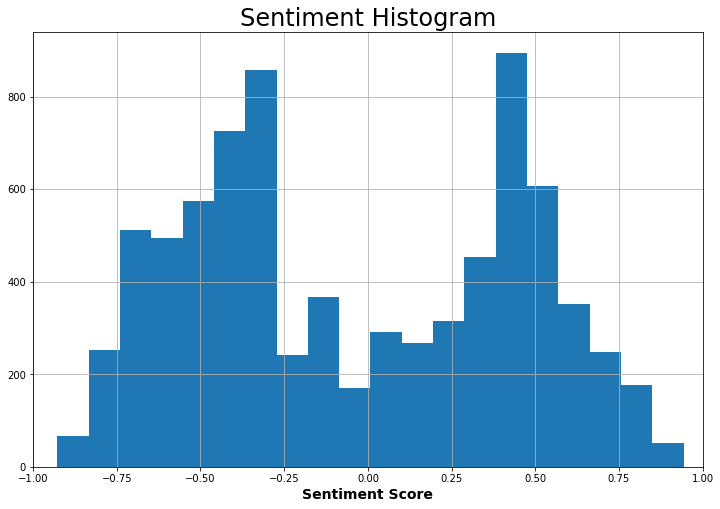

In [41]:
# sentiment distribution

tweet_df['sentiment_scores'] = [get_sentiment(i) for i in tweet_df['text']]

plt.figure(figsize=(12, 8))
plt.title('Sentiment Histogram', fontsize=24)
plt.xlabel('Sentiment Score', fontweight='bold', fontsize=14)
plt.xlim((-1, 1))
plt.grid()

plt.hist([i for i in tweet_df['sentiment_scores'] if abs(i) > 0], bins=20); # 0.1 precision

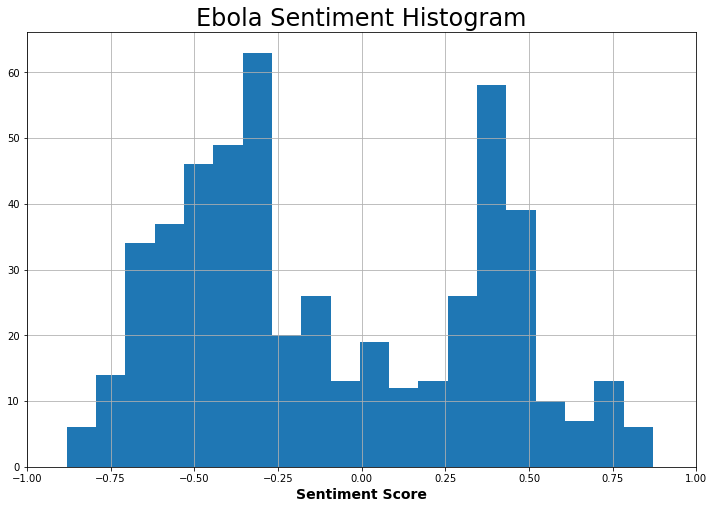

In [42]:
# ebola-sentiment distribution

ebola_indices = [idx for idx, i in enumerate(tweet_df['clean_text']) if 'ebola' in i]
ebola_sentiments = [i for i in tweet_df['sentiment_scores'][ebola_indices] if abs(i) > 0]

plt.figure(figsize=(12, 8))
plt.title('Ebola Sentiment Histogram', fontsize=24)
plt.xlabel('Sentiment Score', fontweight='bold', fontsize=14)
plt.xlim((-1, 1))
plt.grid()

plt.hist(ebola_sentiments, bins=20); # 0.1 precision

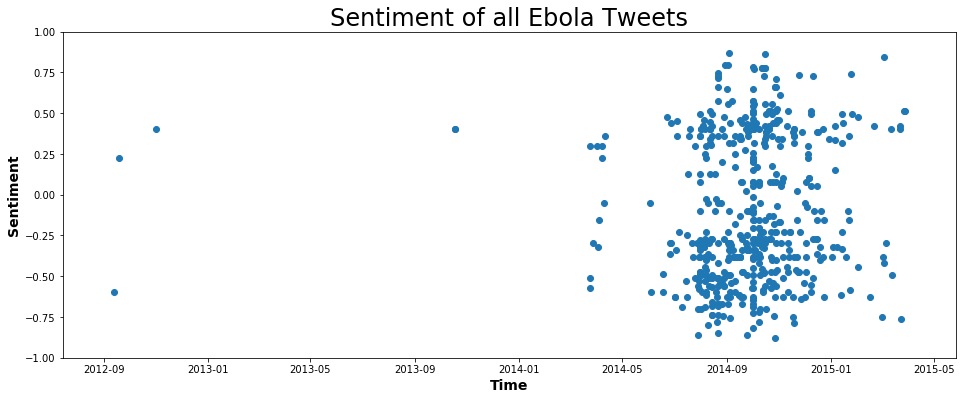

In [43]:
# plotting the sentiment for each ebola tweet independently

ebola_sent_df = tweet_df.iloc[ebola_indices][['date', 'sentiment_scores']]
filtered_ebola_sent = ebola_sent_df[abs(ebola_sent_df['sentiment_scores']) > 0]

plt.figure(figsize=(16, 6))
plt.title('Sentiment of all Ebola Tweets', fontsize=24)
plt.ylabel('Sentiment', fontweight='bold', fontsize=14)
plt.ylim((-1, 1))
plt.xlabel('Time', fontweight='bold', fontsize=14)

plt.scatter(filtered_ebola_sent['date'],
            filtered_ebola_sent['sentiment_scores']);

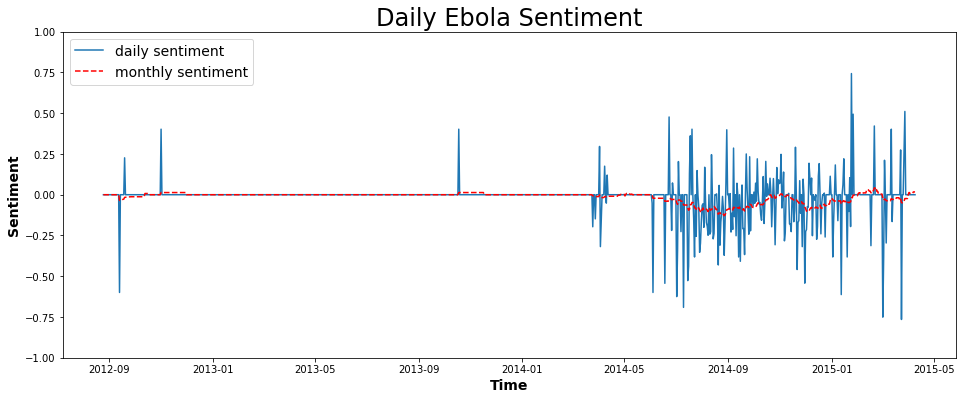

In [44]:
# averaging sentiment for each day - over time

x = sorted(tweet_df['date'].unique())  # time on the x axis

daily_ebola = ebola_sent_df.groupby('date')['sentiment_scores'].mean()
y = [daily_ebola[i] if i in daily_ebola.index else 0 for i in x]

plt.figure(figsize=(16, 6))
plt.title('Daily Ebola Sentiment', fontsize=24)
plt.ylabel('Sentiment', fontweight='bold', fontsize=14)
plt.ylim((-1, 1))
plt.xlabel('Time', fontweight='bold', fontsize=14)

plt.plot(x, y, label='daily sentiment')
plt.plot(x, helpers.moving_avg(y, 30), 'r--', label='monthly sentiment')
plt.legend(fontsize=14);

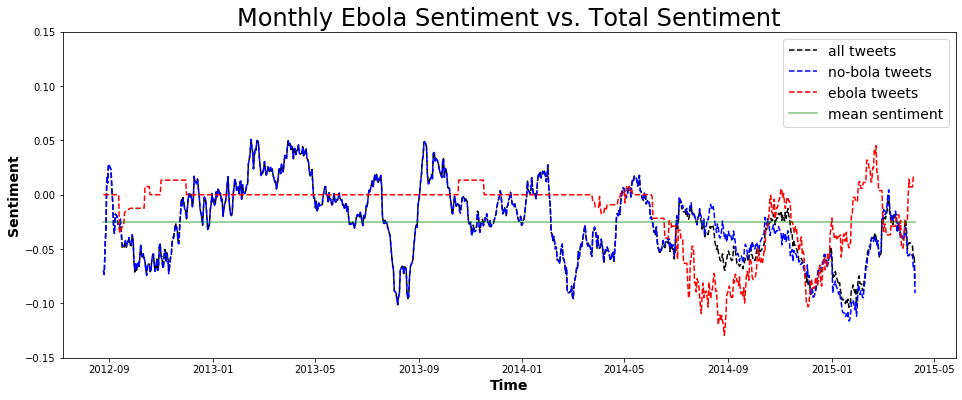

In [58]:
# 30-day averages for all vs ebola

y_all = tweet_df.groupby('date')['sentiment_scores'].mean()

not_ebola_sent = tweet_df.iloc[~tweet_df.index.isin(ebola_indices)][['date', 'sentiment_scores']]
y_not = not_ebola_sent.groupby('date')['sentiment_scores'].mean()
y_not = [y_not[i] if i in y_not.index else 0 for i in x]

plt.figure(figsize=(16, 6))
plt.title('Monthly Ebola Sentiment vs. Total Sentiment', fontsize=24)
plt.ylabel('Sentiment', fontweight='bold', fontsize=14)
plt.ylim((-0.15, 0.15))
plt.xlabel('Time', fontweight='bold', fontsize=14)

plt.plot(x, helpers.moving_avg(y_all, 30), 'k--', label='all tweets')
plt.plot(x, helpers.moving_avg(y_not, 30), 'b--', label='no-bola tweets')
plt.plot(x, helpers.moving_avg(y, 30), 'r--', label='ebola tweets')
plt.plot(x, [tweet_df['sentiment_scores'].mean()]*len(x), 'g', alpha=0.5, label='mean sentiment')

plt.legend(fontsize=14);

# topic modeling

Dimensionality reduction by PCA is used to uncover the inherent patterns within data by decomposing its features into a manageable space that captures the most variance. One important piece of this decomposition is that PCA will assign negative values to its components - in this case, negative words don't make much sense.

Non-negative matrix factorization comes in handy because we can factorize (or break down) a rather large NxM matrix into two smaller Nxt and txM matricies that have no negative values. Why is that special? Because we can set t to be a reasonable number, and then we are left with interpretible components - in a word, topics.

Once we have our text data normalized through tfidf it resembles a sparse matrix, or a data frame with much fewer observations than available cells. Decomposition is necessary and our values are positive, so we invoke NMF.

In [46]:
# step 1, normalize

tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_df=0.9, min_df=5,
                        max_features=5000)

tf = tfidf.fit_transform(tweet_df['clean_text'])

In [47]:
# setting the number of topics has a trade-off between separating
# and overlapping topics - finding a balance is the art

num_topics = 5

nmf = NMF(n_components=num_topics, random_state=42,
          l1_ratio=0.5, alpha=0.1).fit(tf) # use elastic-net loss function

nmf_output = nmf.transform(tf) # transform words to topic scores

nmf_output.shape  # tweets, topics

(12815, 5)

In [48]:
# first tweet's topic adherence

nmf_output[0]

array([0.        , 0.        , 0.        , 0.10375299, 0.        ])

In [49]:
keywords = np.array(tfidf.get_feature_names())
num_words = 10  # random guess, or art?

topic_keywords = []
for topic_weights in nmf.components_:
    top_keyword_locs = (-topic_weights).argsort()[:num_words] # alternate to reversing slice of [-20:]
    topic_keywords.append(keywords[top_keyword_locs])

df_topic_keywords = pd.DataFrame(data=topic_keywords,
                                 columns=['word ' + str(i) for i in range(num_words)],
                                 index=['topic ' + str(i) for i in range(num_topics)])

df_topic_keywords

,word 0,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9
topic 0,video,nh,child,video nh,video ebola,help,dementia,uk,surgery,amp
topic 1,health,care,health care,mental,mental health,insurance,health insurance,exchange,law,plan
topic 2,ebola,patient,liberia,outbreak,ebola patient,ebola outbreak,hospital,case,uk,africa
topic 3,cancer,patient,breast,breast cancer,risk,doctor,drug,may,hospital,test
topic 4,tip,getfit,today,getfit tip,today getfit,eat,day,every,food,calorie


In [50]:
# rename topics, transpose the df - now we have a deliverable

topics = ['random',
          'politics',
          'ebola',
          'cancer',
          'wellness']

df_topic_keywords['topics'] = topics
df_topic_keywords.set_index('topics', inplace=True)
df_topic_keywords.T

topics,random,politics,ebola,cancer,wellness
word 0,video,health,ebola,cancer,tip
word 1,nh,care,patient,patient,getfit
word 2,child,health care,liberia,breast,today
word 3,video nh,mental,outbreak,breast cancer,getfit tip
word 4,video ebola,mental health,ebola patient,risk,today getfit
word 5,help,insurance,ebola outbreak,doctor,eat
word 6,dementia,health insurance,hospital,drug,day
word 7,uk,exchange,case,may,every
word 8,surgery,law,uk,hospital,food
word 9,amp,plan,africa,test,calorie


In [51]:
# random ebola tweet

tweet_df['clean_text'][800]

'ebola vaccine trial interrupted'

In [52]:
# topic adherence

nmf.transform(tf[800])

array([[0.       , 0.       , 0.0553606, 0.       , 0.       ]])

In [53]:
# assign each tweet to its top topic

tweet_df['topic_num'] = [list(i).index(max(i)) for i in nmf_output]

Counter(sorted(tweet_df['topic_num']))

Counter({0: 4308, 1: 1767, 2: 1768, 3: 4099, 4: 873})

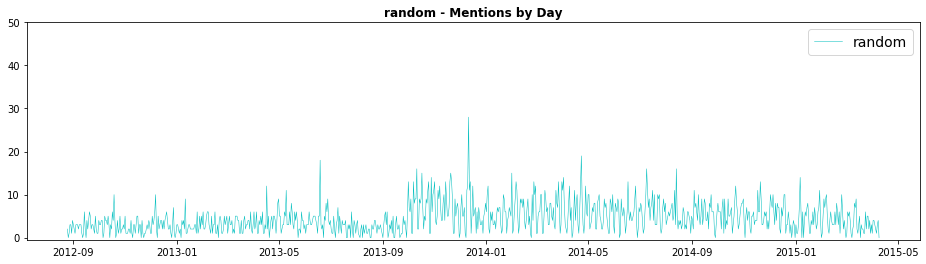

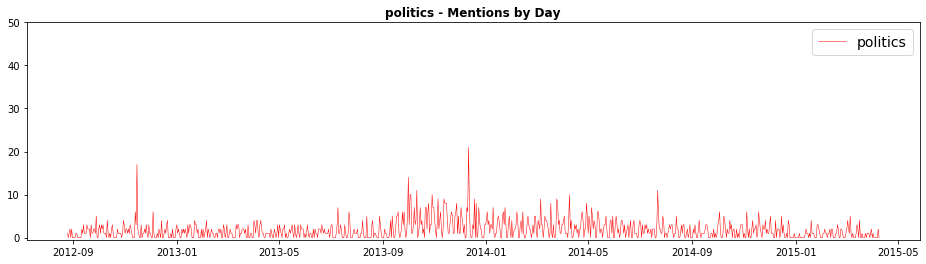

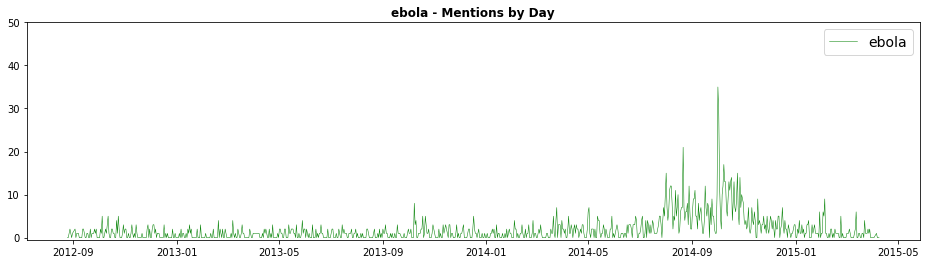

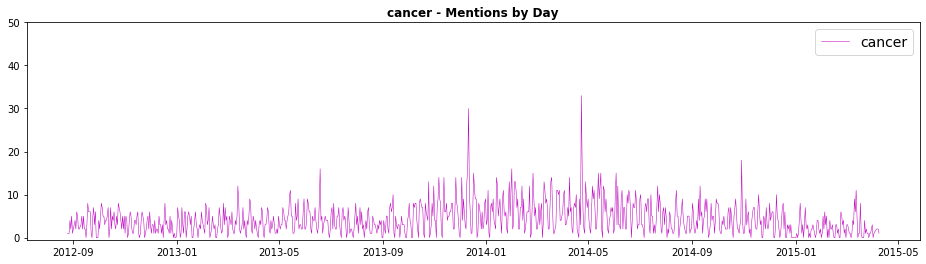

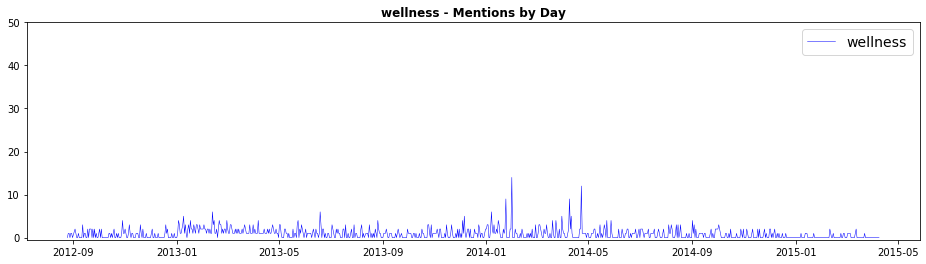

In [54]:
x = sorted(tweet_df['date'].unique())  # time on the x axis
topic_dict = {i: [] for i in range(num_topics)}

for i in x:
    day_counts = tweet_df[tweet_df['date'] == i]['topic_num'].value_counts()  # tweets/day
    for n in range(num_topics):
        topic_dict[n].append(day_counts.get(n, 0))  # append n-tweets or 0

colors = ['c', 'r', 'g', 'm', 'b']

for t in range(num_topics):
    plt.figure(figsize=(16, 4))
    plt.title('{} - Mentions by Day'.format(topics[t]), fontweight='bold')
    plt.ylim(-0.5, 50)
    plt.plot(x, topic_dict[t], c=colors[t],
             linewidth=0.5, label=topics[t])
    plt.legend(fontsize=14)
    plt.show();